# Notebook for building and evaluating LSN

* **Data shapes**
    - X_MR: samples x 2 x ROIs (baseline and follow-up) 
    - X_aux: samples x 4 (gentic, age, clinical_score_bl, clinical_score_followup) #Can be user defined
    - y: samples x n_classes (needs to be one-hot i.e. [0,1] )
    
    
* **network architecture names**
    - MR_shape: number of MR ROIs
    - n_layers: number of layers for MR Siamese net
    - l1,l2, etc: number of nodes in each layer
    - MR_output: number of output nodes (embedding dimension) for each MR branch (baseline, follow-up)
    - use_aux: LSN can be built just with MR or MR + aux_features
    - aux_shape: number of aux features excluding genetic (i.e. apoe4 status)  
    - aux_output: number nodes for aux output (single layer ANN) 
    - output: final output of LSN == number of classes 
    - reg: weight regulalization for the network 
    - Example: net_arch = {'MR_shape':78,'n_layers':4,'l1':50,'l2':50,'l3':50,'l4':25,'MR_output':20,'use_aux':True,'aux_shape':3,'aux_output':2,'output':2,'reg':0.01}

In [1]:
# Basic imports
%matplotlib inline
import tensorflow as tf
import numpy as np
import random
import time
import math
import pandas as pd
from datetime import datetime
import sys 
import os
import pickle
sys.path.append(os.path.relpath("../lib/"))
from lsn import *

In [2]:
df[['APOE4','MMSE_bl','MMSE_var_tp']].values.shape

NameError: name 'df' is not defined

# Real CT + aux data example

In [4]:
kfold_dir = '/data/chamal/projects/nikhil/data/Traj_prediction/ADNI/exp_setup/KFolds/'
exp_name = 'Exp_502_ALL_ADNI_traj_MMSE_tp_var_tp_sKF.pkl'
exp_setup = pd.read_pickle(kfold_dir+exp_name) 
print('exp_name: {}'.format(exp_name))
    
df = exp_setup['df']
ct_cols_bl = list(df.columns[pd.Series(df.columns).str.contains('CT_bl')]) 
ct_cols_followup =list(df.columns[pd.Series(df.columns).str.contains('CT_var_tp')])

# Just a single split (no k-fold) as an example
train_split = int(0.9*len(df))

subject_idx_test = df['PTID'][train_split:]

# Train-test splits
X_MR_train = np.stack((df[ct_cols_bl].values,df[ct_cols_followup].values),axis=1)[:train_split]
X_aux_train = df[['APOE4','MMSE_bl','MMSE_var_tp']].values[:train_split]
y_train = df['traj'].values[:train_split]
y_train = np.squeeze(np.vstack((1-y_train,y_train)).T)

X_MR_test = np.stack((df[ct_cols_bl].values,df[ct_cols_followup].values),axis=1)[train_split:]
X_aux_test = df[['APOE4','MMSE_bl','MMSE_var_tp']].values[train_split:]
y_test = df['traj'].values[train_split:]
y_test = np.squeeze(np.vstack((1-y_test,y_test)).T)

print('shapes of X_MR_train:{}, X_aux_train:{}, y_train:{}, \n\t X_MR_test:{}, X_aux_test:{}, y_test:{}'.format(X_MR_train.shape,X_aux_train.shape,y_train.shape,
                                                                                                                X_MR_test.shape,X_aux_test.shape,y_test.shape)) 

exp_name: Exp_502_ALL_ADNI_traj_MMSE_tp_var_tp_sKF.pkl
shapes of X_MR_train:(1004, 2, 78), X_aux_train:(1004, 3), y_train:(1004, 2), 
	 X_MR_test:(112, 2, 78), X_aux_test:(112, 3), y_test:(112, 2)


/data/chamal/projects/nikhil/code/python/conda/anaconda2/envs/tensorflow_v14/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
# Check differences in aux_feature distributions
print('train aux distributions')
class_0 = np.mean(X_aux_train[y_train[:,0]==0],axis=0)
class_1 = np.mean(X_aux_train[y_train[:,0]==1],axis=0)
print(class_0,class_1)
print('test aux distributions')
class_0 = np.mean(X_aux_test[y_test[:,0]==0],axis=0)
class_1 = np.mean(X_aux_test[y_test[:,0]==1],axis=0)
print(class_0,class_1)

train aux distributions
[ 0.81   25.21   23.3225] [ 0.41059603 28.80298013 28.81291391]
test aux distributions
[ 0.85714286 25.4047619  24.07142857] [ 0.27142857 28.6        28.78571429]


# Train and test a sample LSN

**Note there is no hyper param tuning in this example **

In [9]:
# training params
lr = 0.005
n_epochs = 300
validate_after = 10
batch_size = 50
dropout = 0.75 #keep_prob
verbose = False # Do you want to print perf after every epoch?? 

net_arch = {'MR_shape':78,'n_layers':4,'l1':50,'l2':50,'l3':50,'l4':50,'l5':50,'MR_output':10,
            'use_aux':True,'aux_shape':3,'aux_output':2,'output':2,'reg':0.1}

# minimal perf df --> append CV related attributes downstream. 
perf_df = pd.DataFrame(columns=['subject_id','label','pred_prob','pred_label'])

tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:        
    # Train model    
    data = {'X_MR':X_MR_train,'X_aux':X_aux_train,'y':y_train}    
    if check_data_shapes(data,net_arch):      
        print('train data <-> net_arch check passed')   
        lsn = siamese_net(net_arch)        
        optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(lsn.loss)
        tf.global_variables_initializer().run()

        cur_time = datetime.time(datetime.now())
        print('Start training time: {}'.format(cur_time))                
        lsn, train_metrics = train_lsn(sess, lsn, data, optimizer, n_epochs, batch_size, dropout,validate_after,verbose)
        cur_time = datetime.time(datetime.now())
        print('End training time: {}\n'.format(cur_time))  
      
    else:
        print('train data <-> net_arch check failed')

    # Test model      
    data = {'X_MR':X_MR_test,'X_aux':X_aux_test,'y':y_test}
    if check_data_shapes(data,net_arch):
        print('test data <-> net_arch check passed')   
        _,test_metrics = test_lsn(sess,lsn,data)        
        # populate perf dataframe
        perf_df['subject_id']  = subject_idx_test
        perf_df['label'] = np.argmax(y_test,1)
        perf_df['pred_prob'] = list(test_metrics['test_preds'])
        perf_df['pred_label'] = np.argmax(test_metrics['test_preds'],1)
    else:
        print('test data <-> net_arch check failed')   


train data <-> net_arch check passed
Using MR and aux features
Start training time: 11:24:34.357401
total_batch 1
performance on entire train and valid subsets
epoch 0	 train_acc:0.4441989064216614	 valid_acc:0.4444444477558136

performance on entire train and valid subsets
epoch 10	 train_acc:0.6497237682342529	 valid_acc:0.7373737096786499

performance on entire train and valid subsets
epoch 20	 train_acc:0.6640883684158325	 valid_acc:0.747474730014801

performance on entire train and valid subsets
epoch 30	 train_acc:0.6773480772972107	 valid_acc:0.747474730014801

performance on entire train and valid subsets
epoch 40	 train_acc:0.680662989616394	 valid_acc:0.747474730014801

performance on entire train and valid subsets
epoch 50	 train_acc:0.6784530282020569	 valid_acc:0.7373737096786499

performance on entire train and valid subsets
epoch 60	 train_acc:0.6861878633499146	 valid_acc:0.7373737096786499

performance on entire train and valid subsets
epoch 70	 train_acc:0.69392263889

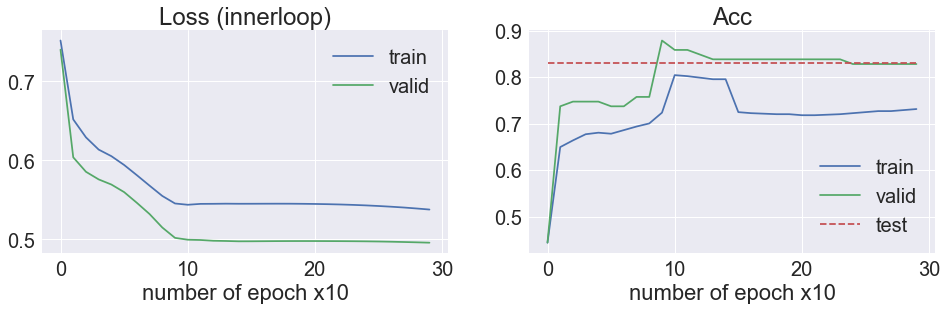

In [13]:
#Plots 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

plt.figure(figsize=(16,9))
plt.style.use('seaborn-white')
sns.set(font_scale=2)
train_loss = train_metrics['train_loss']
valid_loss = train_metrics['valid_loss']
train_acc = train_metrics['train_acc']
valid_acc = train_metrics['valid_acc']

plt.subplot(2,2,1)
plt.plot(train_loss,label='train');
plt.plot(valid_loss,label='valid');
plt.title('Loss (innerloop)')
plt.xlabel('number of epoch x{}'.format(validate_after))
plt.legend()

plt.subplot(2,2,2)
plt.plot(train_acc,label='train');
plt.plot(valid_acc,label='valid');
plt.plot(np.tile(test_metrics['test_acc'],len(train_acc)),'--',label='test')
plt.title('Acc')
plt.xlabel('number of epoch x{}'.format(validate_after))
plt.legend()

/data/chamal/projects/nikhil/code/python/conda/anaconda2/envs/tensorflow_v14/lib/python3.5/site-packages/sklearn/neighbors/base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


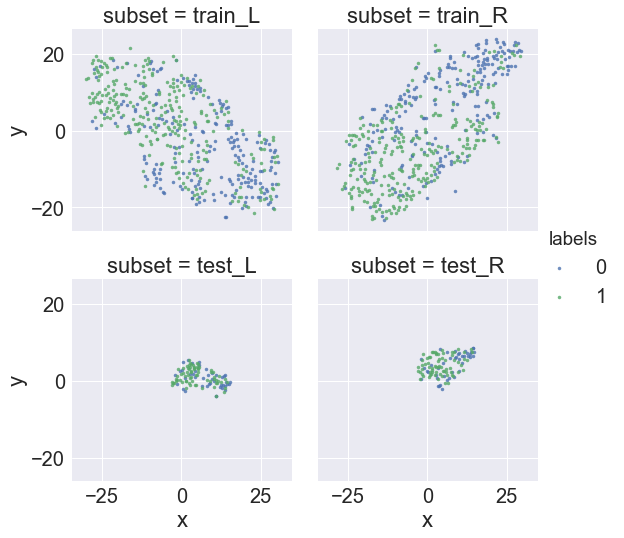

In [14]:
#Plot TSNE
tsne_sampx = 500 #Too slow for large number of samples
train_embed_L = train_metrics['train_feature_L']
train_embed_R = train_metrics['train_feature_R']

test_embed_L = test_metrics['test_feature_L']
test_embed_R = test_metrics['test_feature_R']

train_tsne_embed_L = TSNE(n_components=2,init='pca').fit_transform(train_embed_L[:tsne_sampx])
test_tsne_embed_L = TSNE(n_components=2,init='pca').fit_transform(test_embed_L[:tsne_sampx])
train_tsne_embed_R = TSNE(n_components=2,init='pca').fit_transform(train_embed_R[:tsne_sampx])
test_tsne_embed_R = TSNE(n_components=2,init='pca').fit_transform(test_embed_R[:tsne_sampx])


train_df_L = pd.DataFrame(columns=['x','y','labels','subset'])
test_df_L = pd.DataFrame(columns=['x','y','labels','subset'])
train_df_R = pd.DataFrame(columns=['x','y','labels','subset'])
test_df_R = pd.DataFrame(columns=['x','y','labels','subset'])

train_df_L['x'] = train_tsne_embed_L[:,0] 
train_df_L['y'] = train_tsne_embed_L[:,1] 
train_df_L['labels'] = y_train[:tsne_sampx]
train_df_L['subset'] = np.tile('train_L',len(y_train[:tsne_sampx]))

train_df_R['x'] = train_tsne_embed_R[:,0] 
train_df_R['y'] = train_tsne_embed_R[:,1] 
train_df_R['labels'] = y_train[:tsne_sampx]
train_df_R['subset'] = np.tile('train_R',len(y_train[:tsne_sampx]))

test_df_L['x'] = test_tsne_embed_L[:,0] 
test_df_L['y'] = test_tsne_embed_L[:,1] 
test_df_L['labels'] = y_test[:tsne_sampx]
test_df_L['subset'] = np.tile('test_L',len(y_test[:tsne_sampx]))

test_df_R['x'] = test_tsne_embed_R[:,0] 
test_df_R['y'] = test_tsne_embed_R[:,1] 
test_df_R['labels'] = y_test[:tsne_sampx]
test_df_R['subset'] = np.tile('test_R',len(y_test[:tsne_sampx]))


plot_df = train_df_L.append(train_df_R).append(test_df_L).append(test_df_R)
sns.lmplot(x='x',y='y',hue='labels',col='subset',col_wrap=2, fit_reg=False, markers='.',data=plot_df,size=4);

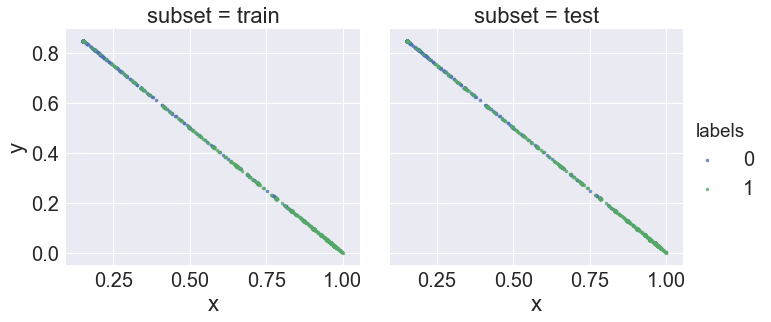

In [102]:
# Plot preds
train_features = train_metrics['train_preds']
test_features = test_metrics['test_preds']

train_df = pd.DataFrame(columns=['x','y','labels','subset'])
test_df = pd.DataFrame(columns=['x','y','labels','subset'])
train_df['x'] = train_features[:,0] 
train_df['y'] = train_features[:,1] 
train_df['labels'] = y_train
train_df['subset'] = np.tile('train',len(y_train))
test_df['x'] = test_features[:,0] 
test_df['y'] = test_features[:,1] 
test_df['labels'] = y_test
test_df['subset'] = np.tile('test',len(y_test))
plot_df = train_df.append(test_df)
sns.lmplot(x='x',y='y',hue='labels',col='subset',fit_reg=False, markers='.',data=plot_df);
